In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from matplotlib.pyplot import imread

%matplotlib inline

Download Fashion MNIST dataset, normalize image data, and build the training set data loader trainloader, load 64 images from the training set each time, and disrupt the order each time

In [75]:
train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('mnist-dataset/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('mnist-dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=64, shuffle=True)

Display an image

This picture is Trouser


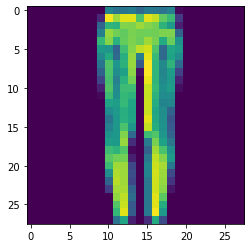

In [76]:
image, label = next(iter(train_loader))

imagedemo = image[3]
imagedemolabel = label[3]

imagedemo = imagedemo.reshape((28,28))

import matplotlib.pyplot as plt
plt.imshow(imagedemo)

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
print(f'This picture is {labels[imagedemolabel]}')

Open the picture in the dataset. There are 64 pieces of 28*28 grayscale images. 

In [77]:
image, label = next(iter(train_loader))
image.shape

torch.Size([64, 1, 28, 28])

In [58]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [59]:
# Instantiate the Classifier class defined above
model = Classifier()

# Define the loss function
criterion = nn.NLLLoss()

# The optimization method is Adam gradient descent method, and the learning rate is 0.003
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 15

train_losses, test_losses = [], []

print('Start training')
for e in range(epochs):
    running_loss = 0
    
    # Traverse all the pictures in the training set. 
    for images, labels in train_loader:
        # Set the derivation results in the optimizer to 0
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Test results
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            #Stop dropout
            model.eval()
            
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                # The right side of the equal sign is the percentage of correct predictions in each batch of 64 test pictures
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        # Resume Dropout
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Training times: {}/{}.. ".format(e+1, epochs),
              "Training error: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test error: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Classification accuracy: {:.3f}".format(accuracy/len(test_loader)))

Start training
Training times: 1/15..  Training error: 0.518..  Test error: 0.432..  Classification accuracy: 0.847
Training times: 2/15..  Training error: 0.381..  Test error: 0.397..  Classification accuracy: 0.859
Training times: 3/15..  Training error: 0.343..  Test error: 0.386..  Classification accuracy: 0.861
Training times: 4/15..  Training error: 0.321..  Test error: 0.362..  Classification accuracy: 0.872
Training times: 5/15..  Training error: 0.304..  Test error: 0.357..  Classification accuracy: 0.874
Training times: 6/15..  Training error: 0.293..  Test error: 0.369..  Classification accuracy: 0.864
Training times: 7/15..  Training error: 0.281..  Test error: 0.421..  Classification accuracy: 0.855
Training times: 8/15..  Training error: 0.276..  Test error: 0.360..  Classification accuracy: 0.876
Training times: 9/15..  Training error: 0.264..  Test error: 0.355..  Classification accuracy: 0.881
Training times: 10/15..  Training error: 0.260..  Test error: 0.385..  Class

Verify model effect

Plot the training error and test error as the number of learning increases

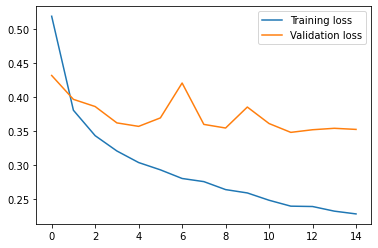

In [60]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

The prediction of the neural network is T-shirt/top，the probability is99.99388456344604%


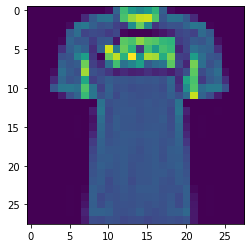

In [61]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

# Convert the test image to a one-dimensional column vector
img = torch.from_numpy(img)
img = img.view(1, 784)

# Predict the category of the picture
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
prediction = labellist[top_class]
probability = float(top_p)
print(f'The prediction of the neural network is {prediction}，the probability is{probability*100}%')

Use the Dropout method to prevent overfitting

In [62]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # 构造Dropout方法，在每次训练过程中都随机“掐死”百分之二十的神经元，防止过拟合。
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # 确保输入的tensor是展开的单列数据，把每张图片的通道、长度、宽度三个维度都压缩为一列
        x = x.view(x.shape[0], -1)
        
        # 在训练过程中对隐含层神经元的正向推断使用Dropout方法
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # 在输出单元不需要使用Dropout方法
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [63]:
model = Classifier()

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 15

train_losses, test_losses = [], []

print('Start training')
for e in range(epochs):
    running_loss = 0
    
    for images, labels in train_loader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            model.eval()
            
            for images, labels in test_loader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Training times: {}/{}.. ".format(e+1, epochs),
              "Training error: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test error: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Classification accuracy: {:.3f}".format(accuracy/len(test_loader)))

Start training
Training times: 1/15..  Training error: 0.606..  Test error: 0.452..  Classification accuracy: 0.833
Training times: 2/15..  Training error: 0.453..  Test error: 0.427..  Classification accuracy: 0.847
Training times: 3/15..  Training error: 0.425..  Test error: 0.393..  Classification accuracy: 0.861
Training times: 4/15..  Training error: 0.405..  Test error: 0.410..  Classification accuracy: 0.856
Training times: 5/15..  Training error: 0.390..  Test error: 0.372..  Classification accuracy: 0.866
Training times: 6/15..  Training error: 0.382..  Test error: 0.389..  Classification accuracy: 0.863
Training times: 7/15..  Training error: 0.370..  Test error: 0.375..  Classification accuracy: 0.872
Training times: 8/15..  Training error: 0.366..  Test error: 0.372..  Classification accuracy: 0.862
Training times: 9/15..  Training error: 0.362..  Test error: 0.381..  Classification accuracy: 0.869
Training times: 10/15..  Training error: 0.357..  Test error: 0.380..  Class

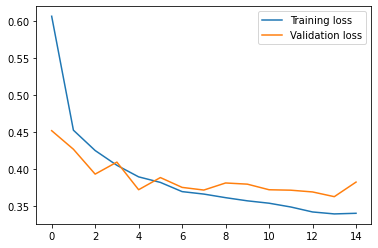

In [64]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

The prediction of the neural network is Shirt，the probability is99.99468326568604%


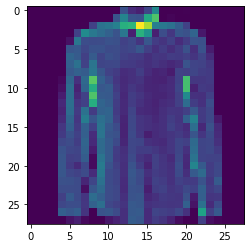

In [65]:
model.eval()
dataiter = iter(test_loader)
images, labels = dataiter.next()
img = images[0]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

img = torch.from_numpy(img)
img = img.view(1, 784)

with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
prediction = labellist[top_class]
probability = float(top_p)
print(f'The prediction of the neural network is {prediction}，the probability is{probability*100}%')

Bayesian Neural Network

Define a standard feedforward neural network of one hidden layer of 1024 units

In [78]:
class NN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output = self.fc1(x)
        output = F.relu(output)
        output = self.out(output)
        return output

In [79]:
train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('mnist-dataset/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('mnist-dataset/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=64, shuffle=True)

In [80]:
net = NN(28*28, 1024, 10)

In [81]:
!pip install pyro-ppl==1.1.0

import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [70]:
log_softmax = nn.LogSoftmax(dim=1)

In [71]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [72]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [82]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
num_iterations = 10
loss = 0
train_losses = []

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,28*28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    train_losses.append(total_epoch_loss_train)
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  172.8917836549441
Epoch  1  Loss  164.67787004583676
Epoch  2  Loss  165.2679865544637
Epoch  3  Loss  166.62894815479913
Epoch  4  Loss  165.95927118198077
Epoch  5  Loss  167.62796999289193
Epoch  6  Loss  167.59773679585456
Epoch  7  Loss  166.95722186393738
Epoch  8  Loss  168.13631524089178
Epoch  9  Loss  165.45867860047022


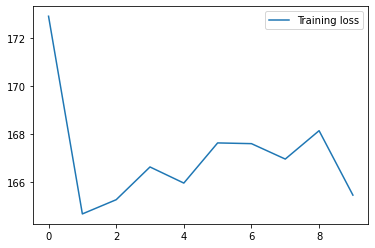

In [83]:
plt.plot(train_losses, label='Training loss')
plt.legend()

In [84]:
num_samples = 10
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,28*28))
    total += labels.size(0)
    correct += np.sum((np.array(predicted) == np.array(labels)).astype("int32"))
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 72 %


In [85]:
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
          "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

In [86]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #plt.imshow(npimg,  cmap='gray')
    #fig.show(figsize=(1,1))
    
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [87]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,28*28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)
    #mean = torch.mean(torch.stack(yhats), 0)
    #return np.argmax(mean, axis=1)

In [44]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True

            if(plot):

                # We'll color code by height, but you could use any scalar
                fracs = N / N.max()

                # we need to normalize the data to 0..1 for the full range of the colormap
                norm = colors.Normalize(fracs.min(), fracs.max())

                # Now, we'll loop through our objects and set the color of each accordingly
                for thisfrac, thispatch in zip(fracs, patches):
                    color = plt.cm.viridis(norm(thisfrac))
                    thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())

    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
        
    return len(labels), correct_predictions, predicted_for_images

In [48]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

Prediction when network can refuse
Total images:  10000
Skipped:  1864
Accuracy when made predictions: 77 %
